In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim, cuda, backends
from torch.autograd import Variable
from torch.utils import data
from torchvision import datasets, transforms, utils

In [ ]:
num_colors = 256 # either 1 or 256
class DynamicBinarization():
    def __call__(self,x):
        return x.bernoulli()*2-1
def Binarize(x):
    return   x.bernoulli()*2-1
#transforms.RandomAffine(
#degrees = 10, translate=None, scale=(0.95,1.05), shear=(0.95,1.05,0.95,1.05), resample=1),
if num_colors == 1:
    trans = transforms.Compose([transforms.ToTensor(), DynamicBinarization()])
else:
    trans = transforms.ToTensor()

tr = data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=trans),
                     batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
te = data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=trans),
                     batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class MaskedConv2d(nn.Conv2d):
    
    def __init__(self, type='B', *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        
        # Mask A) without center pixel
        # Mask B) with center pixel

        # 1 1 1 1 1
        # 1 1 1 1 1
        # 1 1 X 0 0
        # 0 0 0 0 0
        # 0 0 0 0 0

        self.mask = torch.ones_like(self.weight)
        _, _, height, width = self.weight.size()
        
        self.mask[:, :, height // 2, width // 2 + (1 if type=='B' else 0):] = 0
        self.mask[:, :, height // 2 + 1:] = 0

        if cuda:
            self.mask = self.mask.cuda()
        
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)
            

class ResNetBlock(nn.Module):
    
    def __init__(self, num_filters=128):
        super(ResNetBlock, self).__init__()
        
        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters//2, kernel_size=1),
            nn.ReLU(),
            MaskedConv2d(in_channels=num_filters//2, out_channels=num_filters//2, kernel_size=3, padding=1, type='B'),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_filters//2, out_channels=num_filters, kernel_size=1)
        )
        
    def forward(self, x):
        return self.layers(x) + x

class PixelCNN(nn.Module):
    def __init__(self, num_layers=12, num_filters=128,color_levels=1):
        super(PixelCNN, self).__init__()
        
        layers = [MaskedConv2d(in_channels=1,
                               out_channels=num_filters,
                               kernel_size=7,
                               padding=3, type='A')]
        
        for _ in range(num_layers):
            layers.append(ResNetBlock(num_filters=num_filters))
            
        layers.extend([
            nn.ReLU(),
            nn.Conv2d(in_channels=num_filters, out_channels=256, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=color_levels, kernel_size=1)
        ])
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

def sample_images(net,num_colors=1,num_samples=8):
    sample = torch.Tensor(num_samples**2, 1, 28, 28).cuda()
    sample.fill_(0)
    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                if num_colors == 1:
                    out = net(Variable(Binarize(sample)))
                    probs = torch.sigmoid(out[:, :, i, j]).data
                    sample[:, :, i, j] = torch.bernoulli(probs).cuda()
                else:
                    out = net(sample*2-1)
                    probs = torch.softmax(out[:, :, i, j],1).data
                    sample[:, :, i, j] = torch.multinomial(probs, 1).float()/(num_colors-1)
    return sample

In [ ]:
net = PixelCNN(num_filters=64, color_levels=num_colors)
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
if num_colors == 1:
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
else:
    criterion = F.cross_entropy

num_epochs = 50
num_samples = 6
train_plot_data = []
test_plot_data = []

In [ ]:
for epoch in range(num_epochs):
    # train
    err_tr = []
    net.train(True)
    for input, _ in tr:
        if num_colors == 1:
            input = Variable(input.cuda())
            target = Variable(input.data[:,0].unsqueeze(1))/2+1/2*torch.ones_like(input)
        else:
            target = Variable((input.data[:,0] * (num_colors-1)).long().cuda())
            input = Variable((input*2-1).cuda())
        loss = criterion(net(input), target)
        err_tr.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # compute error on test set
    err_te = []

    #net.train(False)
    with torch.no_grad():
        for input, _ in te:
            if num_colors == 1:
                input = Variable(input.cuda())
                target = Variable(input.data[:,0].unsqueeze(1))/2+1/2*torch.ones_like(input)
            else:
                target = Variable((input.data[:,0] * (num_colors-1)).long().cuda())
                input = Variable((input*2-1).cuda())
        loss = criterion(net(input), target)
        err_te.append(loss.item())

        # sample
        sample = sample_images(net,num_colors=num_colors,num_samples=num_samples)
        utils.save_image(sample, 'sample_{:02d}.png'.format(epoch), nrow=num_samples, padding=0)
        train_plot_data.append(err_tr)
        test_plot_data.append(err_te)
    
    
        print('epoch=%d; Train loss=%.7f; Test loss=%.7f'
            % (epoch+1, np.mean(err_tr), np.mean(err_te)))
        
        


epoch=1; Train loss=1.1949605; Test loss=0.8103391
epoch=2; Train loss=0.8229822; Test loss=0.8047646
epoch=3; Train loss=0.8101300; Test loss=0.7022055
epoch=4; Train loss=0.8022929; Test loss=0.7852409
epoch=5; Train loss=0.7967630; Test loss=0.8085930
epoch=6; Train loss=0.7921760; Test loss=0.7427025
epoch=7; Train loss=0.7889880; Test loss=0.8521560
epoch=8; Train loss=0.7851206; Test loss=0.7837142
epoch=9; Train loss=0.7824928; Test loss=0.7606496
epoch=10; Train loss=0.7792740; Test loss=0.6503462
epoch=11; Train loss=0.7770099; Test loss=0.7598320
epoch=12; Train loss=0.7747318; Test loss=0.8053037
epoch=13; Train loss=0.7716703; Test loss=0.8123677
epoch=14; Train loss=0.7723758; Test loss=0.7902336
epoch=15; Train loss=0.7697903; Test loss=0.7517194
epoch=16; Train loss=0.7672398; Test loss=0.6841568
epoch=17; Train loss=0.7650246; Test loss=0.7179495
epoch=18; Train loss=0.7648944; Test loss=0.8297210
epoch=19; Train loss=0.7653036; Test loss=0.7298618
epoch=20; Train loss=

In [ ]:
train_plot_data = torch.tensor(train_plot_data)
torch.save(train_plot_data, 'normal_train_data.pt')
test_plot_data = torch.tensor(test_plot_data)
torch.save(test_plot_data, 'normal_test_data.pt')
torch.save(net.state_dict(), 'Binary_PixelCNN_e{:02d}c{:03d}.pth'.format(epoch,num_colors))

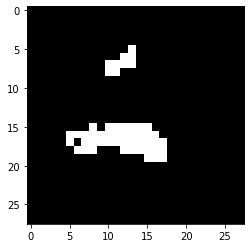

In [ ]:
# Generate 16 images
sample = sample_images(net,num_colors=num_colors,num_samples=num_samples)
utils.save_image(sample, 'Generated_samples/random_sample.png', nrow=num_samples, padding=0)
plt.imshow(sample.cpu().data.numpy()[0,0,:],cmap='gray')
plt.show()

In [ ]:
# Load trained network with 70
net = PixelCNN(num_filters=64)
net.cuda()

checkpoint = torch.load("Binary_PixelCNN_e99c001.pth")
net.load_state_dict(checkpoint)

<All keys matched successfully>

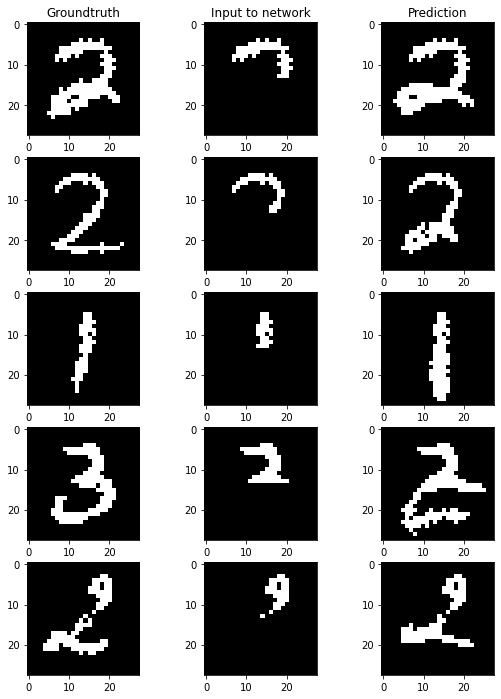

In [ ]:
def plot_half_boys(net,te,num_pics):
  # Test of generating images from half an image
    with torch.no_grad():
        for input, _ in te:
            input = Variable(input.cuda())
            target = Variable(input.data[:,0].unsqueeze(1))/2+1/2*torch.ones_like(input)
            input_plot = torch.Tensor(num_pics, 1, 28, 28).cuda()
            input_plot.fill_(0)
            input_plot[:,:,0:14,:]=target[0:num_pics,:,0:14,:]
            sample = torch.Tensor(num_pics, 1, 28, 28).cuda()
            sample.fill_(0)
            sample[:,:,0:14,:]=target[0:num_pics,:,0:14,:]
            for i in range(14,28):
                for j in range(28):
                    out = net(Variable(Binarize(sample)))
                    probs = torch.sigmoid(out[:, :, i, j]).data
                    sample[:, :, i, j] = torch.bernoulli(probs).cuda()
            break

    plt.figure(figsize=(9,12))
    for i in range(num_pics):
        plt.subplot(num_pics,3,1+3*i), plt.imshow(target.cpu().data.numpy()[i,0,:],cmap='gray')
        if i==0:
            plt.title('Groundtruth')
        plt.subplot(num_pics,3,2+3*i), plt.imshow(input_plot.cpu().data.numpy()[i,0,:],cmap='gray')
        if i==0:
            plt.title('Input to network')
        plt.subplot(num_pics,3,3+3*i), plt.imshow(sample.cpu().data.numpy()[i,0,:],cmap='gray')
        if i==0:
            plt.title('Prediction')

    plt.show()

plot_half_boys(net,te,5)